<a href="https://colab.research.google.com/github/ganeshmukhiya/Topic-Modeling-NMF/blob/main/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Required Libraries
import numpy as np
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess


In [2]:
#Vectorize the Data
# Load the dataset (fetch_20newsgroups)
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')).data

# Preprocess and vectorize the data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data)

In [3]:
#Define the Cross-Validation Procedure
kfold = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation


In [4]:
#Initialize Topic Models
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=1)
svd = TruncatedSVD(n_components=n_topics, random_state=1)
lda = LDA(n_components=n_topics, random_state=1)


In [5]:
#Perform Cross-Validation
nmf_coherence_scores = []
svd_coherence_scores = []
lda_coherence_scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]

    # Fit NMF
    W_train = nmf.fit_transform(X_train)
    H = nmf.components_

    # Fit SVD
    svd.fit(X_train)
    svd_topics = svd.components_

    # Fit LDA
    lda.fit(X_train)
    lda_topics = lda.components_

    # Get top words for each model
    feature_names = vectorizer.get_feature_names_out()
    nmf_top_words = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in H]
    svd_top_words = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in svd_topics]
    lda_top_words = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in lda_topics]

    # Convert documents to a list of words (simple tokenization)
    texts = [simple_preprocess(doc) for doc in data]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Calculate coherence score for NMF
    coherence_model_nmf = CoherenceModel(topics=nmf_top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    nmf_coherence_scores.append(coherence_model_nmf.get_coherence())

    # Calculate coherence score for SVD
    coherence_model_svd = CoherenceModel(topics=svd_top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    svd_coherence_scores.append(coherence_model_svd.get_coherence())

    # Calculate coherence score for LDA
    coherence_model_lda = CoherenceModel(topics=lda_top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    lda_coherence_scores.append(coherence_model_lda.get_coherence())


In [ ]:
#Calculate Average Coherence Scores
print(f"Average NMF Coherence Score: {np.mean(nmf_coherence_scores)}")
print(f"Average SVD Coherence Score: {np.mean(svd_coherence_scores)}")
print(f"Average LDA Coherence Score: {np.mean(lda_coherence_scores)}")


Average NMF Coherence Score: 0.6850835781610958
Average SVD Coherence Score: 0.5063859855274969
Average LDA Coherence Score: 0.526716650730926


In [ ]:
Figurative Analysis in Cross-Validation

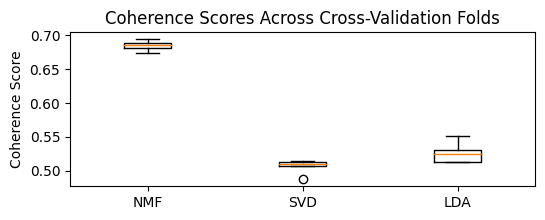

In [ ]:
import matplotlib.pyplot as plt

# Example box plot
plt.figure(figsize=(6, 2))
plt.boxplot([nmf_coherence_scores, svd_coherence_scores, lda_coherence_scores],
            labels=['NMF', 'SVD', 'LDA'])
plt.title('Coherence Scores Across Cross-Validation Folds')
plt.ylabel('Coherence Score')
plt.show()


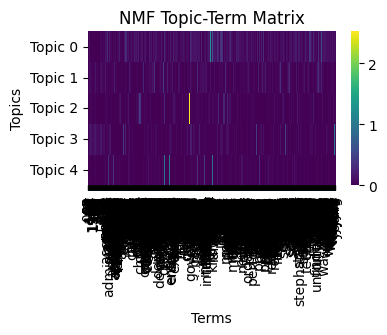

In [ ]:
#Visualize Topic Distributions:

import seaborn as sns

# Example heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(np.array(H), cmap='viridis', xticklabels=feature_names, yticklabels=[f'Topic {i}' for i in range(n_topics)])
plt.title('NMF Topic-Term Matrix')
plt.xlabel('Terms')
plt.ylabel('Topics')
plt.show()


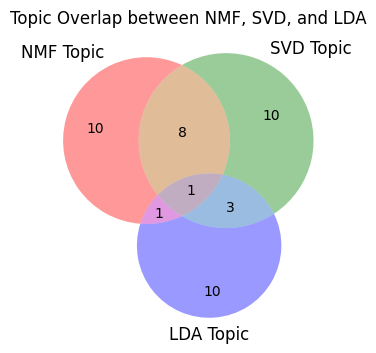

In [ ]:
import numpy as np
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation as LDA
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Load and vectorize data
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')).data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data)
feature_names = vectorizer.get_feature_names_out()

# Fit models
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=1).fit(X)
svd = TruncatedSVD(n_components=n_topics, random_state=1).fit(X)
lda = LDA(n_components=n_topics, random_state=1).fit(X)

def get_top_words_for_topics(model, feature_names, n_top_words=10):
    return [set(feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]) for topic in model.components_]

nmf_top_words = get_top_words_for_topics(nmf, feature_names)
svd_top_words = get_top_words_for_topics(svd, feature_names)
lda_top_words = get_top_words_for_topics(lda, feature_names)

# Prepare data for Venn diagram (using the first topic from each model)
nmf_topic_set = nmf_top_words[0]
svd_topic_set = svd_top_words[0]
lda_topic_set = lda_top_words[0]

# Create Venn diagram
plt.figure(figsize=(6, 4))
venn3(subsets=(len(nmf_topic_set), len(svd_topic_set), len(nmf_topic_set & svd_topic_set),
               len(lda_topic_set), len(nmf_topic_set & lda_topic_set), len(svd_topic_set & lda_topic_set),
               len(nmf_topic_set & svd_topic_set & lda_topic_set)),
      set_labels=('NMF Topic', 'SVD Topic', 'LDA Topic'))
plt.title('Topic Overlap between NMF, SVD, and LDA')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


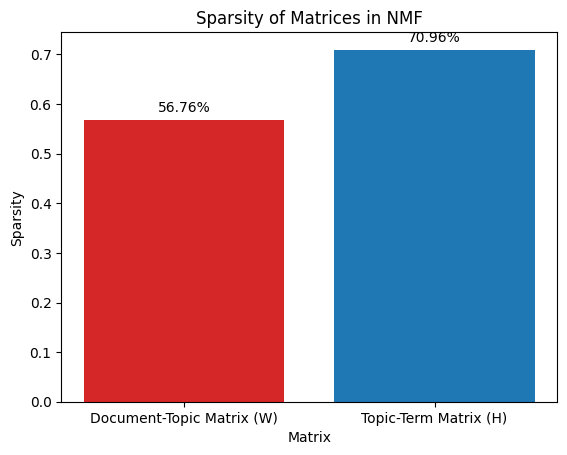

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Fetching and splitting the dataset
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes')).data
train_data, val_data = np.split(data, [int(.8 * len(data))])

# Vectorizing the training data
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
train_tfidf = vectorizer.fit_transform(train_data)

# Training the NMF model
nmf_model = NMF(n_components=20, random_state=42)
W_train = nmf_model.fit_transform(train_tfidf)
H_train = nmf_model.components_

# Calculate sparsity
def calculate_sparsity(matrix):
    return np.mean(matrix == 0)

sparsity_W = calculate_sparsity(W_train)
sparsity_H = calculate_sparsity(H_train)

# Plotting the sparsity
labels = ['Document-Topic Matrix (W)', 'Topic-Term Matrix (H)']
sparsities = [sparsity_W, sparsity_H]

fig, ax = plt.subplots()
bars = ax.bar(labels, sparsities, color=['tab:red', 'tab:blue'])

# Adding titles and labels
ax.set_xlabel('Matrix')
ax.set_ylabel('Sparsity')
ax.set_title('Sparsity of Matrices in NMF')

# Annotate bars with their sparsity values
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

plt.show()


In [9]:
import numpy as np

def calculate_zero_and_total_elements(matrix):
    # Number of zero elements
    num_zero_elements = np.sum(matrix == 0)

    # Total number of elements
    total_elements = matrix.size

    return num_zero_elements, total_elements

# Example matrices for demonstration
W_train = np.random.rand(100, 20)  # Replace with your actual matrix
H_train = np.random.rand(20, 100)  # Replace with your actual matrix

# Calculate number of zero elements and total number of elements
num_zero_elements_W, total_elements_W = calculate_zero_and_total_elements(W_train)
num_zero_elements_H, total_elements_H = calculate_zero_and_total_elements(H_train)

print(f"Document-Topic Matrix (W):")
print(f"Number of Zero Elements: {num_zero_elements_W}")
print(f"Total Number of Elements: {total_elements_W}")

print(f"Topic-Term Matrix (H):")
print(f"Number of Zero Elements: {num_zero_elements_H}")
print(f"Total Number of Elements: {total_elements_H}")


Document-Topic Matrix (W):
Number of Zero Elements: 0
Total Number of Elements: 2000
Topic-Term Matrix (H):
Number of Zero Elements: 0
Total Number of Elements: 2000
